# Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
from src.utils import *

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np

In [78]:
# DATASET_PATH = NIEMCZYK_DATASET_PATH
DATASET_PATH = MARCINIAK_DATASET_PATH

# Labels preparation

In [69]:
def coins_with_no_grade(df):
    df = df[df["title_state"].isna() & df["description_state"].isna()]
    return df 

def coins_with_ambiguity(df):
    df = df[df["title_state"].str.replace(" ","") != df["description_state"].str.replace(" ","")]
    df = df[df["title_state"].notna() & df["description_state"].notna()]
    return df

def unify_states(df):
    df = df[~df.index.isin(coins_with_no_grade(df).index)]
    df = df[~df.index.isin(coins_with_ambiguity(df).index)]
    df["state"] = df["title_state"]
    df.loc[df["state"].isna(), "state"] = df["description_state"]
    df.drop(["description_state", "title_state"], axis=1, inplace = True)
    return df

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_nearest_category_value(grade, categories=["1", "2", "3"]):
    basic_grading_dict_inv = {v: k for k, v in basic_grading_dict.items()}
    categories_in_sheldon = [basic_grading_dict[cat] for cat in categories]
    nearest_sheldon_value = find_nearest(categories_in_sheldon, grade)
    return basic_grading_dict_inv[nearest_sheldon_value]

def get_labels

,date,description,images,link,title,state,sheldon,category
0,"12 czerwca, 10:00",Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/1482/433119_1b.jp...,https://aukcje.gndm.pl/pl/auction/1482/id/8146...,Sztandar 5 złotych 1930,2,52.0,2
1,06 lutego 2021,Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/1236/386388_1b.jp...,https://aukcje.gndm.pl/pl/auction/1236/lot/333...,Sztandar 5 złotych 1930 - GŁĘBOKI,2,52.0,2
2,06 lutego 2021,Opis pozycji\Stan zachowania: 1-\Literatura: C...,['https://img1.onebid.pl/img/1236/330188_1b.jp...,https://aukcje.gndm.pl/pl/auction/1236/lot/333...,Sztandar 5 złotych 1930,1-,61.0,1-
3,03 października 2020,Opis pozycji\Stan zachowania: NGC UNC\Literatu...,['https://img1.onebid.pl/img/996/261269_1b.jpg...,https://aukcje.gndm.pl/pl/auction/996/lot/3336...,Sztandar 5 złotych 1930,NGC UNC,70.0,1
4,03 października 2020,Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/996/287431_1b.jpg...,https://aukcje.gndm.pl/pl/auction/996/lot/3337...,Sztandar 5 złotych 1930,2,52.0,2
...,...,...,...,...,...,...,...,...
157,"08 marca 2010, 21:42",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009701...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"4254. 5 zł 1930 Sztandar, NGC AU details",NGC AU,52.0,2
158,"16 lutego 2010, 13:00",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009599...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"1019. 5 zł 1930 Sztandar, st.3",3,35.0,3
159,"12 grudnia 2009, 21:36",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429010378...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"1565. 5 zł 1930 Sztandar, st.3+",3+,42.0,2-
160,"17 grudnia 2008, 21:45",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009072...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"3545. 5 zł 1930, Sztandar - NGC AU 55",NGC AU 55,55.0,2


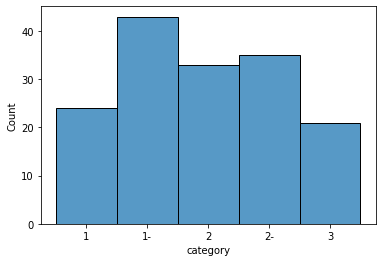

In [80]:
df = pd.read_csv(metadata_path(DATASET_PATH), sep='|')
df = unify_states(df)
df["sheldon"] = df["state"].apply(get_shaldon_value)
df["category"] = df["sheldon"].apply(lambda grade: get_nearest_category_value(grade, categories=["1","1-","2","2-","3"]))

sns.histplot(df['category'].sort_values(), discrete=True )
df